## Table of Contents
[Bound Tightening](#BoundTightening)    
  - [Prototype for bound tightening procedures](#Prototypeforboundtighteningprocedures)  
  - [NO-R](#NO-R)
  - [RR](#RR)
  - [ITER-RR](#ITER-RR) 
  - [LR](#LR)
  
[MILP Model](#MILPModel)  
[Full Model Hyperbolic](#FullModelHyperbolic)  
[Neural Net Example](#NeuralNet)   
[Neural Net Oil Case](#NeuralNetOilCase)  
[Previous Implementations](#PreviousImplementations) 


In [6]:
from gurobipy import *
import pickle
import numpy as np
from copy import deepcopy
import pandas as pd

from neural_net_1 import neural_init

## Bound Tightening <a name="BoundTightening"></a>

In [2]:
def total_neurons(weights):
    """
    Input
    weights : Weights of the neural network
    
    Output
    t : total number of neurons in the neural network  
    """
    t = 0
    for layer in weights:
        t += len(layer[0][0])
    return t

def init_bounds(weights, init):
    """
    weights : weights of the neural network
    init : initial value of the bounds (lb = -init, ub = init)
    """   
    # first outer list : layers
    # second outer list : neurons
    # third outer list : lower and upper bound, respectively
    bounds = [[[-init,init] for j in range(len(weights[k][0]))] for k in range(len(weights))]
    bounds.append([[-init,init]])
    return bounds


def show_bounds(bounds):
    for i, layer in enumerate(bounds):
        if i == 0:
            print("Input Layer")
        elif i == len(bounds) - 1:
            print("Output Layer")
        else:
            print("Layer : {}".format(i+1))
        for neuron in layer:
            print("Lower Bound : {} \t Upper Bound : {}".format(neuron[0],neuron[1]))
            
def bound_objective(model, x, s, k, j, maximize):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[k][j] - s[k][j], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[k][j] - s[k][j], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound


def neurons_at(W, layer):
    # Return the number of neurons of each layer
    return len(W[layer][0][0])

def MAD(bounds):
    soma = 0
    i = 0
    for layer in bounds:
        for neuron in layer:
            i += 1
            soma += abs(neuron[1] - neuron[0])
    return soma / i

def total_of_affected_neurons(bounds):
    activated, deactivated = 0, 0
    for k in bounds[1:]:
        for j in k:
            if j[0] > 0: # lb > 0
                activated += 1
            if j[1] < 0:
                deactivated += 1
    return activated, deactivated
                
                
def empty_model(weights : list, parameters : dict, bounds : list, relax : bool, tight_input : bool ):
    
    # Create the model
    m = Model('empty_model')
    m.Params.LogToConsole = 0 # turn off logs
       
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
      
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = [[m.addVar(lb=0,ub=10) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # negative dump
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
    if relax:
        z = [[m.addVar(lb=0,ub=1) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # binary relaxed activation variable
    else:
        z = [[m.addVar(vtype=GRB.BINARY) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # binary relaxed activation variable
   
    m.update()
    
    for k in range(len(z)): # Iterate over all the hidden layers [1,K-1]
        for j in range(len(z[k])):
            if x[k][j].ub < 0: # Deactivate neuron         
                x[k][j].lb , x[k][j].ub = 0, 0 
                z[k][j].lb, z[k][j].ub = 0, 0
            if x[k][j].lb > 0: # Activate neuron
                s[k][j].lb, s[k][j].ub = 0, 0
                z[k][j].lb, s[k][j].ub = 1, 1             
    m.update()
    
    if tight_input:
        # Input parameters
        mean_x = parameters['mean_x']
        std_x = parameters['std_x']
        mean_y = parameters['mean_y']
        std_y = parameters['std_y']

        # Constraints of the upper and lower bounds of normalized x0
        m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
        m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   

        # Constraints of upper and lower bounds of normalized x1
        m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
        m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    
    
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """  
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k][j] )
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k][j], 'Uk{}j{}'.format(k,j))
                m.addConstr( s[k][j] <= -bounds[k][j][0] * (1 - z[k][j]), 'Lk{}j{}'.format(k,j))
                m.addConstr( x[k][j] >= 0)
                               
            else: # OUTPUT LAYER
                
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )        
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                            
    m.update()
    
    return m, x, s, z, y


## Prototypes for bound tightening procedures <a name="Prototypeforboundtighteningprocedures"></a>


### Prototype 1

In [5]:
def prototype_1(parameters, weights):
    """
    Prototype 1 : Where we create all the constraints and variables before we calculate the bounds
    Each bound is calculated based on the constraints of the layers 0 to K+1
    """
    
    # Create the model
    bounds = init_bounds(weights, 5) # initialize the bounds
    m, x, s, z, y = empty_model(weights, parameters, bounds, relax=False, tight_input=True)
    
    K = len(weights) # Number of layers in the neural network
           
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """  
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True) # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                               
            else: # OUTPUT LAYER
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
                
    return bounds

In [6]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
bounds = prototype_1(parameters, W)
show_bounds(bounds)

Input Layer
Lower Bound : -1.7277260797025065 	 Upper Bound : 1.7277260797025065
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.7277260797023226
Layer : 2
Lower Bound : -0.4882339434791403 	 Upper Bound : 1.4049733476806487
Lower Bound : -1.1470627678666299 	 Upper Bound : 0.5180449379716103
Lower Bound : -0.5486740979052875 	 Upper Bound : 0.5861510771013587
Lower Bound : -1.0164590643683253 	 Upper Bound : 1.0996570156851675
Lower Bound : -0.6680164484813815 	 Upper Bound : 0.997780248387159
Lower Bound : -0.8766326685173365 	 Upper Bound : 1.4492500801308008
Lower Bound : -0.0405785661561358 	 Upper Bound : -0.014906589277280563
Lower Bound : -1.326066667367583 	 Upper Bound : 0.4947591965690897
Lower Bound : -0.8258150676753995 	 Upper Bound : 1.4840626577404041
Lower Bound : -1.4071619088468377 	 Upper Bound : 1.2993859897074527
Layer : 3
Lower Bound : 0.2097287471919794 	 Upper Bound : 1.4122590855572061
Lower Bound : -1.3309314708077844 	 Upper Bound : -0.14099964477406077


### NO-R <a name="NO-R"></a>

In [12]:
def NO_R(parameters, weights, bounds):
    """
    Prototype 0 : Where we create the constraints right before calculating the bounds
    Each bound is calculated based on the constraints of the layers 0 to k
    """
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = [[m.addVar(lb=0,ub=10) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # negative dump
    # z = [[m.addVar(lb=0,ub=1) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # binary relaxed activation variable
    z = [[m.addVar(vtype=GRB.BINARY) for neuron in layer[0] if len(layer[0])] for layer in weights] 
    y = m.addVar(lb=-5,ub=5) # output variable
       
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """  
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k][j] - s[k][j] )
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True) # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                
                # Classic ReLu Formulation
                m.addConstr( x[k][j] <= bounds[k][j][1] * z[k][j] )
                m.addConstr( s[k][j] <= -bounds[k][j][0] * (1 - z[k][j]) )
                m.addConstr( x[k][j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
                
    return bounds

In [13]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W, 5) # initialize the bounds
bounds = NO_R(parameters, W, initial_bounds)
print(MAD(bounds))
show_bounds(bounds)


1.7884889500308327
Input Layer
Lower Bound : -1.7277260797025065 	 Upper Bound : 1.7277260797025065
Lower Bound : -1.7277260797023208 	 Upper Bound : 1.7277260797023226
Layer : 2
Lower Bound : -0.4882339434791394 	 Upper Bound : 1.4049733476806474
Lower Bound : -1.147062767866628 	 Upper Bound : 0.5180449379716094
Lower Bound : -0.5486740979052867 	 Upper Bound : 0.5861510771013592
Lower Bound : -1.0164590643683251 	 Upper Bound : 1.0996570156851577
Lower Bound : -0.6680164484813815 	 Upper Bound : 0.9977802483871594
Lower Bound : -0.8766326685173356 	 Upper Bound : 1.4492500801308013
Lower Bound : -0.0405785661561362 	 Upper Bound : -0.014906589277280169
Lower Bound : -1.3260666673675834 	 Upper Bound : 0.49475919656909007
Lower Bound : -0.8258150676753999 	 Upper Bound : 1.4840626577404015
Lower Bound : -1.4071619088468372 	 Upper Bound : 1.299385989707453
Layer : 3
Lower Bound : 0.20972874719197954 	 Upper Bound : 1.4122590855571977
Lower Bound : -1.3309314708077835 	 Upper Bound : 

### RR <a name="RR"></a>

In [7]:
def RR(parameters, weights, init_bounds):
    """
    parameters : dictionary with some parameters of the neural net input 
    weights : numpy array with the neural net weights  
    bounds : numpy array with the initial bounds
    """
    
    K = len(weights) # Number of layers in the neural network
    bounds = deepcopy(init_bounds)
    m, x, s, z, y = empty_model(weights, parameters, bounds, relax=True, tight_input=False)
     
    #"""
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    #"""
    for k in range(1, K+1): # Iterate over all layers of the neural net [1,K]
        neuronios = neurons_at(weights, k-1) # Number of neurons in each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True)  # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                assert bounds[k][j][1] >= bounds[k][j][0]
                
                # First Method (ITER-RR doesn't work, but the bounds are ok)
                #m.remove(m.getConstrByName('Uk{}j{}'.format(k,j)))         
                #m.remove(m.getConstrByName('Lk{}j{}'.format(k,j)))
                #m.update()
                #m.addConstr( x[k][j] <= bounds[k][j][1] * z[k][j], 'Uk{}j{}'.format(k,j)) 
                #m.addConstr( s[k][j] <= -bounds[k][j][0] * (1 - z[k][j]), 'Lk{}j{}'.format(k,j)) 
                
                # Second Method
                # Change the constraint by updating variable z coeffcient (bounds)
                m.getConstrByName('Lk{}j{}'.format(k,j)).rhs = - bounds[k][j][0] # lb_constr = - new_lb -- > -new_lb + old_lb * z
                m.chgCoeff(m.getConstrByName('Uk{}j{}'.format(k,j)), z[k][j], -bounds[k][j][1]) # lb_constr = -new_lb + new_lb * z = (1-z) * new_lb                  
                m.chgCoeff(m.getConstrByName('Lk{}j{}'.format(k,j)), z[k][j], -bounds[k][j][0]) # ub_constr = -new_ub * z   # lb_constr = -new_lb + new_lb * z = (1-z) * new_lb
                m.update()

                                   
            else: # OUTPUT LAYER           
                # Bounds of output     
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
       
    return bounds

In [8]:
initial_b = init_bounds(W,5)
b1 = RR(parameters, W, initial_b)
print('MAD_RR : without tight_input = 5.723449065976529')
print('MAD_RR : with tight_input = 2.0869210379427754')
# show_bounds(b1)

MAD_RR : without tight_input = 5.723449065976529
MAD_RR : with tight_input = 2.0869210379427754


In [9]:
b1 = init_bounds(W,5)
for i in range(15):
    b1 = RR(parameters, W, b1)

print('RR : without tight_input = 5.6284917644398105')
print('MAD_RR : with tight_input = 2.0869210379427754')
# show_bounds(b1)
    

RR : without tight_input = 5.6284917644398105
MAD_RR : with tight_input = 2.0869210379427754


### RR_1

In [10]:
def RR_1(parameters, weights, init_bounds):
    
    bounds = deepcopy(init_bounds)
    K = len(weights) # Number of layers in the neural network

    m, x, s, z, y = empty_model(weights, parameters, bounds,relax=True, tight_input=False)
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub

    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        m, x, s, z, y = empty_model(weights, parameters, bounds,relax=True, tight_input=False)
        for j in range(neuronios): # Iterate over the neurons of the layer
            
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """              
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True)  # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                assert bounds[k][j][1] >= bounds[k][j][0]

            else: # OUTPUT LAYER           
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
        
    return bounds

In [11]:
initial_b = init_bounds(W,5)    
b1 = RR_1(parameters, W, initial_b)
print("Reset each layer")
print('RR_1 : without tight_input = 5.754163176454779')
print('MAD_RR_1 : with tight_input = 2.0869210379427754')
print("Reset each neuron")
print('RR_1 : without tight_input = 5.723449065976529')
print('MAD_RR_1 : with tight_input = 2.086921037942775')
print(MAD(b1))
# show_bounds(b1) 

Reset each layer
RR_1 : without tight_input = 5.754163176454779
MAD_RR_1 : with tight_input = 2.0869210379427754
Reset each neuron
RR_1 : without tight_input = 5.723449065976529
MAD_RR_1 : with tight_input = 2.086921037942775
5.754163176454779


In [12]:
b1 = init_bounds(W,5)  
for i in range(15):
    b1 = deepcopy(RR_1(parameters, W, b1))
print("Reset each layer")   
print('RR_1 : without tight_input = 5.628491763922233')
print('MAD_RR_1 : with tight_input = 2.0869210379427754')
print("Reset each neuron")
print('RR_1 : without tight_input = 5.62849177705657')
print('MAD_RR_1 : with tight_input = 2.086921037942775')
print(MAD(b1))
# show_bounds(b1)    

Reset each layer
RR_1 : without tight_input = 5.628491763922233
MAD_RR_1 : with tight_input = 2.0869210379427754
Reset each neuron
RR_1 : without tight_input = 5.62849177705657
MAD_RR_1 : with tight_input = 2.086921037942775
5.628491763922233


### ITER-RR <a name="ITER-RR"></a>

In [13]:
def ITER_RR(parameters, weights, init_bounds, max_iter, ref):
    
    i = 0 # iterator
    ratio = 0 # [0-1] range
    m_0 = MAD(init_bounds) # MAD of the initial bounds
    bounds = deepcopy(init_bounds) 
    
    while ratio <= ref  and  i <= max_iter:
        bounds = RR(parameters, weights, bounds)
        m = MAD(bounds)
        ratio = m / m_0
        m_0 = m
        print(ratio)
        
        i += 1
    
    return bounds

In [14]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_b = init_bounds(W,5)
iter_bounds = ITER_RR(parameters, W, initial_b, 200, 0.999)
print('MAD_ITERR_1 Reset each layer : without tight_input = 5.629024545346948')
print('MAD_ITERR_1 Reset each neuron : without tight_input = 5.628725336200936')
print('MAD_ITERR 1°method : without tight_input = 5.6287253361775385')
print('MAD_ITERR 2°method : without tight_input = 5.628725336180575')

print(MAD(iter_bounds))
show_bounds(iter_bounds) 

0.5723449065976529
0.9854466840243837
0.9982234876019775
0.9997497814958624
MAD_ITERR_1 Reset each layer : without tight_input = 5.629024545346948
MAD_ITERR_1 Reset each neuron : without tight_input = 5.628725336200936
MAD_ITERR 1°method : without tight_input = 5.6287253361775385
MAD_ITERR 2°method : without tight_input = 5.628725336180575
5.628725336180575
Input Layer
Lower Bound : -5.0 	 Upper Bound : 5.0
Lower Bound : -5.0 	 Upper Bound : 5.0
Layer : 2
Lower Bound : -2.280092579151267 	 Upper Bound : 3.1978191342204805
Lower Bound : -2.7016477610642537 	 Upper Bound : 2.0948830097913747
Lower Bound : -1.3791366579706432 	 Upper Bound : 1.6608176194131372
Lower Bound : -3.020396940410137 	 Upper Bound : 3.008684500566642
Lower Bound : -1.911662610665964 	 Upper Bound : 2.575270786881447
Lower Bound : -3.022565369240344 	 Upper Bound : 3.6518346071243286
Lower Bound : -0.06470609452874312 	 Upper Bound : 0.009404481039382517
Lower Bound : -3.0503680650144815 	 Upper Bound : 2.19018152

### LR <a name="LR"></a>

In [15]:
def teste2(model,x,s,maximize,new,neuronios):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[new+neuronios] - s[new+neuronios], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[new+neuronios] - s[new+neuronios], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound



def layer_relax(bounds, weights, k, j, previous_x, parameters):
    m = Model('LRR_neuron')
    m.Params.LogToConsole = 0 # turn off logs
    
    if k == 1:       
        # Input parameters
        mean_x = parameters['mean_x']
        std_x = parameters['std_x']
        mean_y = parameters['mean_y']
        std_y = parameters['std_y']
        
        # Model Variables
        previous_x = [m.addVar(lb=-1, ub=5) for i in range(len(weights[0][0]))] # decision variables
        
        # Constraints of the upper and lower bounds of normalized x0
        m.addConstr( previous_x[0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
        m.addConstr( previous_x[0] <= (1 - mean_x[0])/std_x[0] )   

        # Constraints of upper and lower bounds of normalized x1
        m.addConstr( previous_x[1] >= (-1 - mean_x[1])/std_x[1] )
        m.addConstr( previous_x[1] <= (1 - mean_x[1])/std_x[1] )

        
    x_0 = [m.addVar(lb=-1,ub=5) for i in range(len(previous_x))]
    s = m.addVar(lb=0,ub=10)
    z = m.addVar(lb=0,ub=1)
    x = m.addVar(lb=-1,ub=5)
    
    for var1,var2 in zip(x_0,previous_x):
        print(var1,var2)
        m.addConstr(var1.obj == var2.obj)

    # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k )
    m.addConstr( sum( weights[k-1][0][i][j] * x_0[i] for i in range(len(weights[k-1][0])))
        + weights[k-1][1][j] == x - s )
    
    m.setObjective(x - s, GRB.MAXIMIZE)
    m.optimize()
    ub = m.ObjVal
    
    m.setObjective(x - s, GRB.MINIMIZE)
    m.optimize()
    lb = m.ObjVal
    
    
    # Classic ReLu Formulation
    m.addConstr( x <= bounds[aux,0] * z )
    m.addConstr( s <= -bounds[aux,1] * (1 - z ))
    m.addConstr( x >= 0)
            
    return ub, lb, x
        
    


In [16]:
def LRR(parameters, weights):
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    bounds = inicialize_bounds(weights)
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
           
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Model Variables
    x_0 = [m.addVar(lb=-1, ub=5) for i in range(len(weights[0][0]))] # decision variables
    y = m.addVar(lb=-5,ub=5) # output variable
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x_0[0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x_0[0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x_0[1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x_0[1] <= (1 - mean_x[1])/std_x[1] )
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x_0[i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x_0[i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[i,1], bounds[i,0] = lb, ub
    
    previous = [x_0]
    current = [[]]
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                """ 

                # print('layer ',k, ' neuron ',j)
                x = m.addVar(lb=-1,ub=5)
                s = m.addVar(lb=0,ub=10) 
                z = m.addVar(lb=0,ub=1)          

                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x - s )
          
                bounds[aux,0] = teste3(m,x,s,True)
                bounds[aux,1] = teste3(m,x,s,False)
                assert bounds[aux,0] >= bounds[aux,1]                   
                
                # Classic ReLu Formulation
                m.addConstr( x <= bounds[aux,0] * z )
                m.addConstr( s <= -bounds[aux,1] * (1 - z ))
                m.addConstr( x >= 0)
                current[0].append(x)            
                
                # m.remove(s)
                # m.remove(z)
                # m.update()
                
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * previous[0][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[aux,1], bounds[aux,0] = lb, ub        
            
            aux += 1
        # for var in previous[0]:
        #    m.remove(var)
        m.update()
         
        previous[0] = current[0]
        current[0] = []
        
    
    return bounds

In [15]:
def LRR(parameters, weights, initial_bounds):
        
    bounds = deepcopy(initial_bounds)
    K = len(weights) # Number of layers in the neural network
    m, x, s, z, y = empty_model(weights, parameters, bounds, relax=True, tight_input=False)
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0][i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0][i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[0][i][0], bounds[0][i][1] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            m, x, s, z, y = empty_model(weights, parameters, bounds, relax=True, tight_input=False)
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """  
                
                bounds[k][j][1] = bound_objective(m, x, s, k, j, True) # upper bound 
                bounds[k][j][0] = bound_objective(m, x, s, k, j, False) # lower bound
                               
            else: # OUTPUT LAYER
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[k][j][0], bounds[k][j][1] = lb, ub
                
    return bounds

In [16]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W,5)
bounds_LRR = LRR(parameters, W, initial_bounds)
MAD(bounds_LRR)
# show_bounds(bounds_LRR)

5.723449065976529

### MILP Model <a name="MILPModel"></a>

In [17]:
def milp_model(parameters, weights, bounds, relax, tight_input):
    # Create MILP Model
    m, x, s, z, y = empty_model(weights, parameters, bounds, relax, tight_input)
    
    # Optimize the model
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * parameters['std_y'] + parameters['mean_y']))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0][0].x, x[0][0].x * parameters['std_x'][0] + parameters['mean_x'][0]))
    print('X1 Normalized {}    Real {}'.format(x[0][1].x, x[0][1].x * parameters['std_x'][1] + parameters['mean_x'][1]))

    print('binarias')
    

In [18]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W,5)
milp_model(parameters, W, NO_R(parameters, W, initial_bounds), relax=False, tight_input=False)

Output
Normalized 1.4888470857111855    Real 2.007926616017677
Input
Xo Normalized 1.3917479214956043    Real 0.8055373695205482
X1 Normalized -0.18102157112060677    Real -0.1047744623683611
binarias


In [19]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W,5)
for bound in [RR,NO_R,LRR]:
    c = total_of_affected_neurons(bound(parameters, W, initial_bounds))
    print("{}".format(bound.__name__))
    print("Number of activated neurons {}".format(c[0]))
    print("Number of deactivated neurons {}".format(c[1]))
    print("_____________________________________________")
    

RR
Number of activated neurons 0
Number of deactivated neurons 0
_____________________________________________
NO_R
Number of activated neurons 2
Number of deactivated neurons 2
_____________________________________________
LRR
Number of activated neurons 2
Number of deactivated neurons 1
_____________________________________________


### Full Model Hyperbolic <a name="FullModelHyperbolic"></a>

In [306]:
def model_flying_elephants(weights : list, parameters : dict, bounds : list, relax : bool, tight_input : bool ):
    
    # Create the model
    m = Model('flying_elephants')
    #m.Params.LogToConsole = 0 # turn off logs
       
    # Local Variables
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    t = 0.5
      
    # Model Variables
    x = [[m.addVar(lb=neuron[0], ub=neuron[1]) for neuron in layer] for layer in bounds[:K]] # decision variables
    s = [[m.addVar(lb=0,ub=10) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # negative dump
    a = [[m.addVar(lb=-10,ub=10) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # auxiliary variable
    y = m.addVar(lb=bounds[K][0][0],ub=bounds[K][0][1]) # output variable
    if relax:
        z = [[m.addVar(lb=0,ub=1) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # binary relaxed activation variable
    else:
        z = [[m.addVar(vtype=GRB.BINARY) for neuron in layer[0] if len(layer[0]) != len(W[0][0])] for layer in weights] # binary relaxed activation variable
   
    m.update()
    
    for k in range(len(z)): # Iterate over all the hidden layers [1,K-1]
        for j in range(len(z[k])):
            if x[k][j].ub < 0: # Deactivate neuron         
                x[k][j].lb , x[k][j].ub = 0, 0 
                z[k][j].lb, z[k][j].ub = 0, 0
            if x[k][j].lb > 0: # Activate neuron
                s[k][j].lb, s[k][j].ub = 0, 0
                z[k][j].lb, s[k][j].ub = 1, 1             
    m.update()
    
    
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    if tight_input:

        # Constraints of the upper and lower bounds of normalized x0
        m.addConstr( x[0][0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
        m.addConstr( x[0][0] <= (1 - mean_x[0])/std_x[0] )   

        # Constraints of upper and lower bounds of normalized x1
        m.addConstr( x[0][1] >= (-1 - mean_x[1])/std_x[1] )
        m.addConstr( x[0][1] <= (1 - mean_x[1])/std_x[1] )
       
         
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Bounds            : bounds[layer][neuron][lower = 0 or upper = 1]
                Weights           : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron] 
                Decision variable : x[layer][neuron]
                Auxiliary variable: a[layer][neuron]
                Negative dump     : s[layer][neuron]
                Binary variable   : z[layer][neuron]
                """  
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == s[k][j] )
                
                m.addConstr( x[k][j] == 0.5 * (s[k][j] + a[k][j]) ) 
                m.addConstr( a[k][j] * a[k][j] == s[k][j] * s[k][j] + t * t )
                
                # Classic ReLu Formulation
                # m.addConstr( x[k][j] <= bounds[k][j][1] * z[k][j], 'Uk{}j{}'.format(k,j))
                # m.addConstr( s[k][j] <= -bounds[k][j][0] * (1 - z[k][j]), 'Lk{}j{}'.format(k,j))
                # m.addConstr( x[k][j] >= 0)
                        
            else: # OUTPUT LAYER
                
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )        
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1][i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                            
    m.update()
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)  
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * std_y + mean_y))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0][0].x, x[0][0].x * std_x[0] + mean_x[0]))
    print('X1 Normalized {}    Real {}'.format(x[0][1].x, x[0][1].x * std_x[1] + mean_x[1]))


    print('binarias')
    print(len(z))


In [ ]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
initial_bounds = init_bounds(W,5)
b_NO_R = NO_R(parameters, W, initial_bounds)
model_flying_elephants(W, parameters, b_NO_R, relax=False, tight_input=True)


### Neural Net Example <a name="NeuralNet"></a>
 

In [149]:
import keras
import numpy as np
from keras.layers import Dense
from sklearn import preprocessing
import pickle
import itertools



#  Cria um array de -1 a 1 espaçado 400 vezes iguais
x1 = np.linspace(-1, 1, 400) # var 1
x2 = np.linspace(-1, 1, 400) # var 2

x = np.array(list(itertools.product(x1, x2)))

# Função descrita pela rede neural
y = np.sin(2 * x[:, 0]) + np.cos(x[:, 1])

#  Média e Desvio Padrão da entrada
mean_x = np.mean(x, axis=0)
std_x = np.std(x, axis=0)

#  Média e Desvio Padrão da saída
mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)

parameters = {'x': x, 'y': y,
            'mean_x': mean_x, 'mean_y': mean_y,
            'std_x': std_x, 'std_y': std_y}

x = parameters['x']
y = parameters['y']

mean_x = parameters["mean_x"]
print("mean_x =", mean_x)

std_x = parameters['std_x']
print("std_x =", std_x)

mean_y = parameters['mean_y']
print("mean_y =", mean_y)

std_y = parameters['std_y']
print("std_y =", std_y)

#  Normalização da entrada e da saída
x_norm = (x - mean_x) / std_x
y_norm = (y - mean_y) / std_y

#  Camadas da Rede Neural ReLu
model = keras.models.Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(x_norm, y_norm, epochs=20)  # nb_epoch=20

res = model.evaluate(x_norm, y_norm)

print(res)


weights = list(map(lambda layer: layer.get_weights(), model.layers))


mean_x = [-1.31450406e-17 -7.09751702e-17]
std_x = [0.57879545 0.57879545]
mean_y = 0.8407163056516141
std_y = 0.7839692346971384
Epoch 1/20
5000/5000 [==============================] - 3s 538us/step - loss: 0.0278 - accuracy: 0.0000e+00
Epoch 2/20
5000/5000 [==============================] - 3s 521us/step - loss: 3.0246e-04 - accuracy: 0.0000e+00
Epoch 3/20
5000/5000 [==============================] - 3s 508us/step - loss: 2.0010e-04 - accuracy: 0.0000e+00
Epoch 4/20
5000/5000 [==============================] - 3s 519us/step - loss: 1.7787e-04 - accuracy: 0.0000e+00
Epoch 5/20
5000/5000 [==============================] - 3s 514us/step - loss: 1.6533e-04 - accuracy: 0.0000e+00
Epoch 6/20
5000/5000 [==============================] - 3s 523us/step - loss: 1.5501e-04 - accuracy: 0.0000e+00
Epoch 7/20
5000/5000 [==============================] - 3s 523us/step - loss: 1.4745e-04 - accuracy: 0.0000e+00
Epoch 8/20
5000/5000 [==============================] - 3s 516us/step - loss: 1.4313e-04 -

### Neural Net Oil Case <a name="NeuralNetOilCase"></a>

In [7]:
import keras
import numpy as np
from keras.layers import Dense
from sklearn import preprocessing
import pickle
import itertools

def oil_model(normalize : bool = False):
    d = {'poco': {(411648.0, 33.08): 199.72, (366020.44, 33.08): 193.07, (320392.89, 33.08): 184.83, (274765.33, 33.08): 174.28, (229137.78, 33.08): 159.8, (183510.22, 33.08): 140.75, (137882.67, 33.08): 112.99, (92255.11, 33.08): 74.37, (411648.0, 29.4): 209.61, (366020.44, 29.4): 203.43, (320392.89, 29.4): 195.75, (274765.33, 29.4): 185.91, (229137.78, 29.4): 172.73, (183510.22, 29.4): 154.35, (137882.67, 29.4): 127.0, (92255.11, 29.4): 87.24, (411648.0, 25.73): 219.34, (366020.44, 25.73): 213.67, (320392.89, 25.73): 206.57, (274765.33, 25.73): 197.4, (229137.78, 25.73): 185.19, (183510.22, 25.73): 168.15, (137882.67, 25.73): 141.52, (92255.11, 25.73): 100.68, (411648.0, 22.05): 228.92, (366020.44, 22.05): 223.77, (320392.89, 22.05): 217.33, (274765.33, 22.05): 208.88, (229137.78, 22.05): 197.5, (183510.22, 22.05): 182.05, (137882.67, 22.05): 156.71, (92255.11, 22.05): 115.0, (411648.0, 18.38): 238.19, (366020.44, 18.38): 233.66, (320392.89, 18.38): 227.89, (274765.33, 18.38): 220.27, (229137.78, 18.38): 209.86, (183510.22, 18.38): 195.24, (137882.67, 18.38): 172.42, (92255.11, 18.38): 130.3, (411648.0, 14.7): 247.82, (366020.44, 14.7): 243.34, (320392.89, 14.7): 238.29, (274765.33, 14.7): 231.6, (229137.78, 14.7): 222.27, (183510.22, 14.7): 208.88, (137882.67, 14.7): 188.08, (92255.11, 14.7): 147.65, (46627.56, 14.7): 64.17, (411648.0, 11.03): 257.19, (366020.44, 11.03): 253.69, (320392.89, 11.03): 249.16, (274765.33, 11.03): 242.67, (229137.78, 11.03): 234.58, (183510.22, 11.03): 222.69, (137882.67, 11.03): 204.09, (92255.11, 11.03): 166.5, (46627.56, 11.03): 83.48, (411648.0, 7.35): 265.84, (366020.44, 7.35): 263.37, (320392.89, 7.35): 259.71, (274765.33, 7.35): 254.62, (229137.78, 7.35): 247.25, (183510.22, 7.35): 236.64, (137882.67, 7.35): 220.47, (92255.11, 7.35): 186.89, (46627.56, 7.35): 121.69, (411648.0, 3.68): 273.41, (366020.44, 3.68): 272.13, (320392.89, 3.68): 269.91, (274765.33, 3.68): 266.36, (229137.78, 3.68): 260.69, (183510.22, 3.68): 251.32, (137882.67, 3.68): 237.0, (92255.11, 3.68): 209.61, (46627.56, 3.68): 145.18, (411648.0, 0.0): 277.58, (366020.44, 0.0): 277.43, (320392.89, 0.0): 276.81, (274765.33, 0.0): 275.58, (229137.78, 0.0): 273.21, (183510.22, 0.0): 268.98, (137882.67, 0.0): 260.18, (92255.11, 0.0): 239.63, (46627.56, 0.0): 179.27}}
    a = np.zeros((len(d['poco']),3))
    a[0:,0:2], a[0:,-1] = list(d['poco'].keys()), list(d['poco'].values())

    x = a[0:,:2]
    y = a[0:,-1]

    #  Média e Desvio Padrão da entrada
    mean_x = [np.mean(x[0:,0], axis=0), np.mean(x[0:,1], axis=0)]
    std_x = [np.std(x[0:,0], axis=0), np.std(x[0:,1], axis=0)]

    #  Média e Desvio Padrão da saída
    mean_y = np.mean(y, axis=0)
    std_y = np.std(y, axis=0)

    print("mean_x1 =", mean_x[0])
    print("std_x1 =", std_x[0])

    print("mean_x2 =", mean_x[1])
    print("std_x2 =", std_x[1])

    print("mean_y =", mean_y)
    print("std_y =", std_y)

    #  Normalização da entrada e da saída
    if normalize:
        a_norm = np.zeros((len(d['poco']),3))
        a_norm[0:,0] = (x[0:,0] - mean_x[0]) / std_x[0]
        a_norm[0:,1] = (x[0:,1] - mean_x[1]) / std_x[1]
        a_norm[0:,2] = (y - mean_y) / std_y
        x = a_norm[0:,:2] # x_norm
        y = a_norm[0:,-1] # y_norm

    #  Camadas da Rede Neural ReLu
    model = keras.models.Sequential()
    model.add(Dense(10, input_dim=2, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.fit(x, y, epochs=250, verbose=0)  # nb_epoch=20
    res = model.evaluate(x, y)
    print(res)
    
    weights = list(map(lambda layer: layer.get_weights(), model.layers))
    return weights, mean_x, std_x, mean_y, std_y, x, y, a, model


In [8]:
oil_W, mean_x, std_x, mean_y, std_y, x_norm, y_norm, train_data, model  = oil_model(normalize=True)

mean_x1 = 239873.67294117645
std_x1 = 112342.82167066597
mean_x2 = 15.999529411764703
std_x2 = 10.542224221825897
mean_y = 205.21470588235294
std_y = 52.551473468752754
3/3 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.0000e+00
[0.005994805134832859, 0.0]


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [10]:
x = train_data[0:,:2]
y = train_data[0:,-1]

### 3D representation

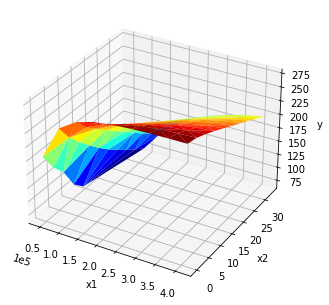

In [18]:
fig = plt.figure()
ax = Axes3D(fig)
plt.rcParams['figure.figsize'] = [1.2*6.4, 1.2*4.8]
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.dist = 10 # the distance from the center visible point in data coordinates
ax.plot_trisurf(x[0:,0], x[0:,1], y, cmap=cm.jet)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

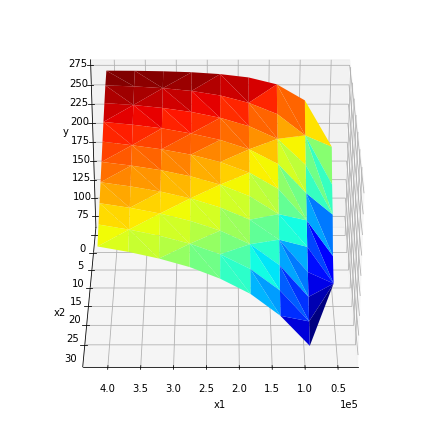

In [19]:
fig = plt.figure()
ax = Axes3D(fig)
# plt.rcParams['figure.figsize'] = [1.2*6.4, 1.2*4.8]
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.azim = 90 # The azimuth is the rotation around the z axis [ 0 means "looking from x2" 90 means "looking from x1"]
#ax.dist = 10 # the distance from the center visible point in data coordinates
#ax.elev = 10 # is the angle between the eye and the xy plane
ax.plot_trisurf(x[0:,0], x[0:,1], y, cmap=cm.jet)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

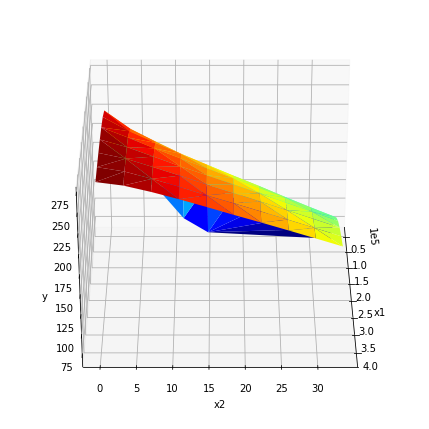

In [20]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.azim = 0
ax.plot_trisurf(x[0:,0], x[0:,1], y, cmap=cm.jet)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

### 2D representation

In [11]:
d = {'poco': {(411648.0, 33.08): 199.72, (366020.44, 33.08): 193.07, (320392.89, 33.08): 184.83, (274765.33, 33.08): 174.28, (229137.78, 33.08): 159.8, (183510.22, 33.08): 140.75, (137882.67, 33.08): 112.99, (92255.11, 33.08): 74.37, (411648.0, 29.4): 209.61, (366020.44, 29.4): 203.43, (320392.89, 29.4): 195.75, (274765.33, 29.4): 185.91, (229137.78, 29.4): 172.73, (183510.22, 29.4): 154.35, (137882.67, 29.4): 127.0, (92255.11, 29.4): 87.24, (411648.0, 25.73): 219.34, (366020.44, 25.73): 213.67, (320392.89, 25.73): 206.57, (274765.33, 25.73): 197.4, (229137.78, 25.73): 185.19, (183510.22, 25.73): 168.15, (137882.67, 25.73): 141.52, (92255.11, 25.73): 100.68, (411648.0, 22.05): 228.92, (366020.44, 22.05): 223.77, (320392.89, 22.05): 217.33, (274765.33, 22.05): 208.88, (229137.78, 22.05): 197.5, (183510.22, 22.05): 182.05, (137882.67, 22.05): 156.71, (92255.11, 22.05): 115.0, (411648.0, 18.38): 238.19, (366020.44, 18.38): 233.66, (320392.89, 18.38): 227.89, (274765.33, 18.38): 220.27, (229137.78, 18.38): 209.86, (183510.22, 18.38): 195.24, (137882.67, 18.38): 172.42, (92255.11, 18.38): 130.3, (411648.0, 14.7): 247.82, (366020.44, 14.7): 243.34, (320392.89, 14.7): 238.29, (274765.33, 14.7): 231.6, (229137.78, 14.7): 222.27, (183510.22, 14.7): 208.88, (137882.67, 14.7): 188.08, (92255.11, 14.7): 147.65, (46627.56, 14.7): 64.17, (411648.0, 11.03): 257.19, (366020.44, 11.03): 253.69, (320392.89, 11.03): 249.16, (274765.33, 11.03): 242.67, (229137.78, 11.03): 234.58, (183510.22, 11.03): 222.69, (137882.67, 11.03): 204.09, (92255.11, 11.03): 166.5, (46627.56, 11.03): 83.48, (411648.0, 7.35): 265.84, (366020.44, 7.35): 263.37, (320392.89, 7.35): 259.71, (274765.33, 7.35): 254.62, (229137.78, 7.35): 247.25, (183510.22, 7.35): 236.64, (137882.67, 7.35): 220.47, (92255.11, 7.35): 186.89, (46627.56, 7.35): 121.69, (411648.0, 3.68): 273.41, (366020.44, 3.68): 272.13, (320392.89, 3.68): 269.91, (274765.33, 3.68): 266.36, (229137.78, 3.68): 260.69, (183510.22, 3.68): 251.32, (137882.67, 3.68): 237.0, (92255.11, 3.68): 209.61, (46627.56, 3.68): 145.18, (411648.0, 0.0): 277.58, (366020.44, 0.0): 277.43, (320392.89, 0.0): 276.81, (274765.33, 0.0): 275.58, (229137.78, 0.0): 273.21, (183510.22, 0.0): 268.98, (137882.67, 0.0): 260.18, (92255.11, 0.0): 239.63, (46627.56, 0.0): 179.27}}
oil_df = pd.DataFrame(d['poco'].items())
oil_df[['lift','whp']] = oil_df[0].apply(lambda x: pd.Series(str(x).strip('()').split(",")))
oil_df.drop(0,axis = 1,inplace=True)
oil_df.columns = ['oil','lift', 'whp']
oil_df.set_index(['lift', 'whp'],inplace=True)
oil_unique = oil_df.groupby(level=[1,0]).mean()
oil_unique


oil
whp   lift             
 0.0  137882.67  260.18
      183510.22  268.98
      229137.78  273.21
      274765.33  275.58
      320392.89  276.81
...                 ...
 7.35 320392.89  259.71
      366020.44  263.37
      411648.0   265.84
      46627.56   121.69
      92255.11   186.89

[85 rows x 1 columns]

Text(0, 0.5, 'oil')

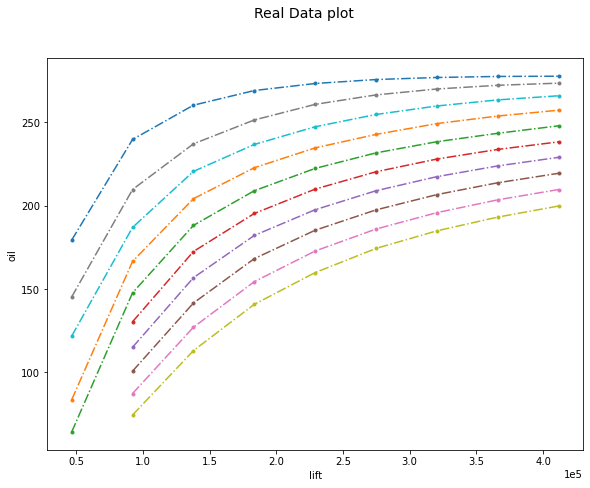

In [14]:
fig = plt.gcf()
fig.suptitle("Real Data plot ", fontsize=14)
plt.rcParams['figure.figsize'] = [1.5*6.4, 1.5*4.8]
for whp in oil_unique.index.get_level_values(0).unique():
    df = oil_unique.loc[whp].copy()
    df.index = df.index.map(float)
    df.sort_index(inplace=True)
    plt.plot(df.index, df['oil'],'.-.')

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
fig.axes[0].set_xlabel('lift')
fig.axes[0].set_ylabel('oil')

Text(0, 0.5, 'oil')

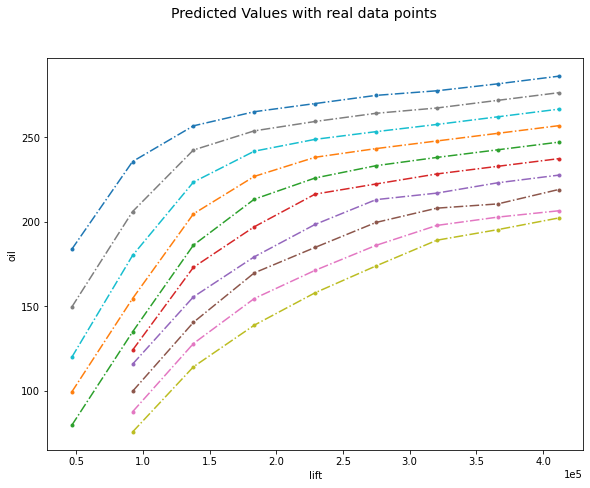

In [13]:
fig = plt.gcf()
fig.suptitle("Predicted Values with real data points ", fontsize=14)
plt.rcParams['figure.figsize'] = [1.5*6.4, 1.5*4.8]
for whp in oil_unique.index.get_level_values(0).unique():
    df = oil_unique.loc[whp].copy()
    df.index = df.index.map(float)
    df.sort_index(inplace=True)
    y_pred = model.predict([[(lift - mean_x[0]) / std_x[0], (float(whp) - mean_x[1]) / std_x[1]] for lift in df.index])
    plt.plot(df.index, (y_pred * std_y) + mean_y,'.-.')
    

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
fig.axes[0].set_xlabel('lift')
fig.axes[0].set_ylabel('oil')

Text(0, 0.5, 'y')

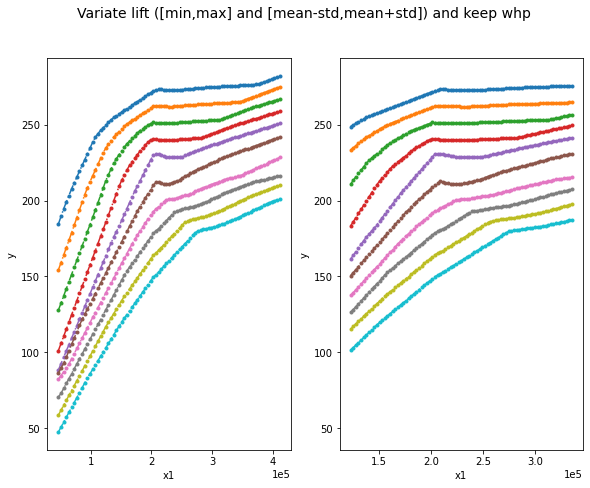

In [110]:
t_x_norm = np.array(x_norm).copy()
t_x_norm[0:,0] = np.linspace(min(t_x_norm[0:,0]), max(t_x_norm[0:,0]), 85) # min -- > max
l = list(set(t_x_norm[0:,1]))
l.sort()
t_x1 = t_x_norm[0:,0] * std_x[0] + mean_x[0]

fig = plt.gcf()
fig.suptitle("Variate lift ([min,max] and [mean-std,mean+std]) and keep whp ", fontsize=14)
plt.rcParams['figure.figsize'] = [1.5*6.4, 1.5*4.8]
plt.subplot(121,label='[min,max]')
for x2 in l:
    t_x_norm[0:,1] = x2 # unique values
    t_y_norm = model.predict(t_x_norm)
    t_y = (t_y_norm * std_y) + mean_y
    a = plt.plot(t_x1, t_y, '.-.')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
fig.axes[0].set_xlabel('x1')
fig.axes[0].set_ylabel('y')

t_x_norm[0:,0] = np.linspace(np.mean(t_x_norm[0:,0]) - np.std(t_x_norm[0:,0]), np.mean(t_x_norm[0:,0]) + np.std(t_x_norm[0:,0]) , 85) # min -- > max
t_x1 = t_x_norm[0:,0] * std_x[0] + mean_x[0]
plt.subplot(122,label='[mean-std, mean+std]',sharey=fig.axes[0])
for x2 in l:
    t_x_norm[0:,1] = x2 # unique values
    t_y_norm = model.predict(t_x_norm)
    t_y = (t_y_norm * std_y) + mean_y
    plt.plot(t_x1, t_y, '.-.')   
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
fig.axes[1].set_xlabel('x1')
fig.axes[1].set_ylabel('y')

Text(0, 0.5, 'y')

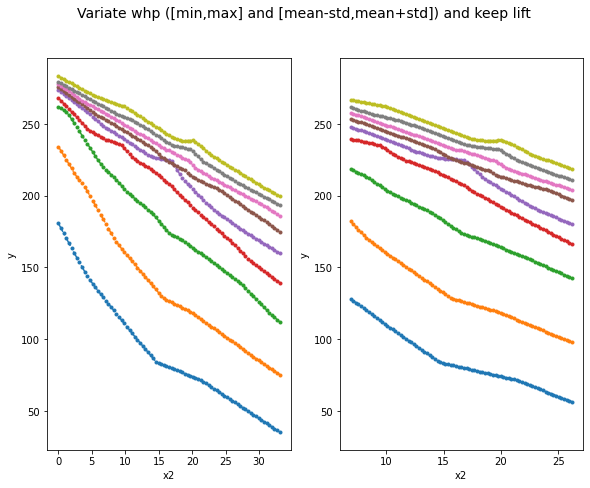

In [103]:
t_x_norm = np.array(x_norm).copy()
t_x_norm[0:,1] = np.linspace(min(t_x_norm[0:,1]), max(t_x_norm[0:,1]), 85) # min -- > max
l = list(set(t_x_norm[0:,0]))
l.sort()
t_x2 = t_x_norm[0:,1] * std_x[1] + mean_x[1]

fig = plt.gcf()
fig.suptitle("Variate whp ([min,max] and [mean-std,mean+std]) and keep lift ", fontsize=14)
plt.rcParams['figure.figsize'] = [1.5*6.4, 1.5*4.8]
plt.subplot(121,label='[min,max]')
for x1 in l:
    t_x_norm[0:,0] = x1 # unique values
    t_y_norm = model.predict(t_x_norm)
    t_y = (t_y_norm * std_y) + mean_y
    a = plt.plot(t_x2, t_y, '.-.')
fig.axes[0].set_xlabel('x2')
fig.axes[0].set_ylabel('y')

t_x_norm[0:,1] = np.linspace(np.mean(t_x_norm[0:,1]) - np.std(t_x_norm[0:,1]), np.mean(t_x_norm[0:,1]) + np.std(t_x_norm[0:,1]) , 85) # min -- > max
t_x1 = t_x_norm[0:,1] * std_x[1] + mean_x[1]
plt.subplot(122,label='[mean-std, mean+std]',sharey=fig.axes[0])
for x1 in l:
    t_x_norm[0:,0] = x1 # unique values
    t_y_norm = model.predict(t_x_norm)
    t_y = (t_y_norm * std_y) + mean_y
    plt.plot(t_x1, t_y, '.-.')   
fig.axes[1].set_xlabel('x2')
fig.axes[1].set_ylabel('y')

### Previous Implementations <a name="PreviousImplementations"></a>

In [63]:
# função desatualizada
def inicialize_bounds(weights):
    """
    Input
    weights : Weights of the neural network
    
    Output
    bounds : a zeros numpy array shapped as (total_neurons + len(input_dim), input_dim)
    """
    t = total_neurons(weights) + len(weights[0])
    bounds = np.zeros((t,2))
    return bounds

# função desatualizada
def bound_model(model, x, s, k, j, maximize):
    """
    Input
    model : model to optimize
    x, s  : variables of the model
    k, j  : layer and neuron, respectively
    maximize : objetive of the model (True == maximize False == minimize)
    
    Output
    new_bound : bound generated after the bound tightening procedure
    """
    if maximize:
        model.setObjective(x[k,j] - s[k,j], GRB.MAXIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    else:
        model.setObjective(x[k,j] - s[k,j], GRB.MINIMIZE)
        model.optimize()
        new_bound = model.ObjVal
    return new_bound

In [64]:
def bound_tightening(parameters, weights):
    
    # Create the model
    m = Model('bound_tightening')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    bounds = inicialize_bounds(weights)
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = m.addVars(K, nK,lb=-5,ub=5) # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, lb=0, ub=1) # binary activation variable
    y = m.addVar(lb=-5,ub=5) # output variable
       
    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0,0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0,0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0,1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0,1] <= (1 - mean_x[1])/std_x[1] )
    
    
    for i in range(len(W[0])): # iterates over the neural net inputs
        # Bounds of input
        m.setObjective(x[0,i], GRB.MAXIMIZE)
        m.optimize()
        ub = m.ObjVal
        m.setObjective(x[0,i], GRB.MINIMIZE)
        m.optimize()
        lb = m.ObjVal
        bounds[i,1], bounds[i,0] = lb, ub
    
    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k,j] - s[k,j] )
                
                
                bounds[aux,0] = bound_model(m, x, s, k, j, True)
                bounds[aux,1] = bound_model(m, x, s, k, j, False)
                
                # Classic ReLu Formulation
                m.addConstr( x[k,j] <= bounds[aux,0] * z[k,j] )
                m.addConstr( s[k,j] <= -bounds[aux,1] * (1 - z[k,j]) )
                m.addConstr( x[k,j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
                
                # Bounds of output
                m.setObjective(y, GRB.MAXIMIZE)
                m.optimize()
                ub = m.ObjVal
                m.setObjective(y, GRB.MINIMIZE)
                m.optimize()
                lb = m.ObjVal
                bounds[aux,1], bounds[aux,0] = lb, ub
                print(lb,ub)
            
            aux += 1
    
    return bounds

In [65]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
bounds = bound_tightening(parameters, W)
bounds

-2.246551803949021 1.7364051413861032


array([[ 1.72772608, -1.72772608],
       [ 1.72772608, -1.72772608],
       [ 0.64205439, -0.27340875],
       [ 0.96719348, -0.73286807],
       [ 1.17378792, -0.48834118],
       [ 0.2331374 , -1.15255043],
       [ 1.15094301, -0.25402936],
       [ 1.03169151, -0.20633246],
       [ 0.80162674, -0.75380247],
       [ 0.50661042, -0.83868536],
       [ 1.05711069, -0.11309143],
       [ 1.04564983, -0.71581283],
       [-0.22943133, -1.18742514],
       [ 0.82950059, -0.24681179],
       [ 0.5584421 , -0.26065242],
       [ 0.89848343, -0.49654192],
       [ 0.96073047, -0.16462877],
       [ 1.21993548, -0.34380913],
       [ 1.12247633, -0.07704481],
       [ 0.27382051, -0.70819428],
       [ 0.75028852,  0.05015983],
       [ 0.72975842, -0.18671328],
       [ 0.60837369, -0.68422108],
       [ 1.00806358, -0.44320637],
       [ 1.5012147 , -0.13275513],
       [ 1.15488415, -0.18326089],
       [ 1.03560569, -0.67558208],
       [ 0.2016631 , -2.89911724],
       [ 1.20067041,

In [43]:
def main_model_with_bounds(parameters, weights, bounds):
    
    # Create the model
    m = Model('bt')
    m.Params.LogToConsole = 0 # turn off logs
    
    # Local Variables
    aux = 2 # index of the bounds array
    K = len(weights) # Number of layers in the neural network
    nK = max(map(lambda l: len(l[0][0]), W))  # Size of the biggest layer
    
    # Model Variables
    x = m.addVars(K, nK,lb=bounds[0,1],ub=bounds[0,0]) # decision variables
    s = m.addVars(K, nK, lb=0, ub=10) # negative dump
    z = m.addVars(K, nK, vtype=GRB.BINARY) # binary activation variable
    y = m.addVar(lb=bounds[-1,1],ub=bounds[-1,0]) # output variable

    # Input parameters
    mean_x = parameters['mean_x']
    std_x = parameters['std_x']
    mean_y = parameters['mean_y']
    std_y = parameters['std_y']
    
    # Constraints of the upper and lower bounds of normalized x0
    m.addConstr( x[0,0] >= (-1 - mean_x[0])/std_x[0] ) # "-1" and "1" are the maximum and minimum values of x0, respectively
    m.addConstr( x[0,0] <= (1 - mean_x[0])/std_x[0] )   
    
    # Constraints of upper and lower bounds of normalized x1
    m.addConstr( x[0,1] >= (-1 - mean_x[1])/std_x[1] )
    m.addConstr( x[0,1] <= (1 - mean_x[1])/std_x[1] )

    for k in range(1, K+1): # Iterate over the hidden layers unitl it reaches the output layer of the neural net
        neuronios = neurons_at(weights, k-1) # Number of neurons of each layer
        for j in range(neuronios): # Iterate over the neurons of the layer
            if k != K: # HIDDEN LAYERS
                """
                Weights : W[layer][weights = 0 or bias = 1][inputs of the previous layer][neuron]
                Input   : x[layer][variable]
                Negative part : s[layer][variable]
                
                """ 
                
                # Rule of the hidden layers output ( W^{k-1} * x^{k-1} + BIAS = x^k - s^k ) 
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0])))
                    + weights[k-1][1][j] == x[k,j] - s[k,j] )
                
                # Classic ReLu Formulation
                if bounds[aux,0] < 0:
                    z[k,j].lb , z[k,j].ub = 0, 0
                if bounds[aux,1] > 0:
                    z[k,j].lb , z[k,j].ub = 1, 1
                    
                m.addConstr( x[k,j] <= bounds[aux,0] * z[k,j] )
                m.addConstr( s[k,j] <= - bounds[aux,1] * (1 - z[k,j]) )
                m.addConstr( x[k,j] >= 0)
                               
            else: # OUTPUT LAYER
                # Rule of the output layer ( W^{k-1} * x^{k-1} + BIAS = y )
                m.addConstr( sum( weights[k-1][0][i][j] * x[k-1,i] for i in range(len(weights[k-1][0]))) + weights[k-1][1][j] == y )
            
            aux += 1
    
    m.setObjective(y, GRB.MAXIMIZE)
    m.update()
    m.setParam("OutputFlag", 1)
    m.setParam("MIPGap", 1e-4)
    m.setParam("NonConvex", 2);
    m.optimize()

    print('Output')
    print('Normalized {}    Real {}'.format(y.x, y.x * std_y + mean_y))
  
    print('Input')
    print('Xo Normalized {}    Real {}'.format(x[0,0].x, x[0,0].x * std_x[0] + mean_x[0]))
    print('X1 Normalized {}    Real {}'.format(x[0,1].x, x[0,1].x * std_x[1] + mean_x[1]))


    print('binarias')
    print(len(z))


In [44]:
W = pickle.load(open('model.pickle', 'rb'))
parameters = neural_init()
b = bound_tightening(parameters, W)
main_model_with_bounds(parameters, W, b)


NameError: name 'bound_tightening' is not defined